# LABS-12: Value

In this lab we will explore and observe how a model performs over different classes using our kNN model that we built in the Analytics lab. We will be using the Fairlearn package to calculate various metrics to help us understand how our model performs across different classes.

Check out their [user guide](https://fairlearn.org/v0.10/user_guide/fairness_in_machine_learning.html) for more information on the package!

If you are working through collab, be sure to run this pip install cell!

In [29]:
!pip install fairlearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [30]:
# import packages

import pandas as pd #data ingestion & cleaning
import numpy as np #numbers

# modeling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Fairness metrics
import fairlearn.metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, true_positive_rate, false_positive_rate, selection_rate, demographic_parity_ratio

# visualization
import matplotlib.pyplot as plt

## Recreate the model
First you will rebuild the model that you made in LABS-9: Analytics.

### Read in the data
The data you are reading in is the **cleaned** data that you created in LABS-9. Upload it to folders in collab if your using it.

In [31]:
## read in cleaned data
model_data = pd.read_csv("imdb_movies_cleaned.csv")

For the FairLearn package, the target variable must be coded as 0/1.

In [32]:
# Recode 'score' as 0 (low) or 1 (high)
model_data['score'] = model_data['score'].map({'low': 0, 'high': 1})

### Seperate features from target

In [33]:
# features: all columns except 'score'
features = model_data.drop('score', axis=1)

# Target: score column
target = model_data['score']

### Dummy variables

In [34]:
## create dummy variables for the features dataframe
features = pd.get_dummies(features)

# preview the new features dataframe
features.head()

,budget_x,revenue,year,country_AU,country_ES,country_FR,country_GB,country_HK,country_IT,country_JP,...,top_lang_ Norwegian,top_lang_ Polish,top_lang_ Portuguese,top_lang_ Russian,top_lang_ Spanish,top_lang_ Swedish,top_lang_ Tagalog,top_lang_ Thai,top_lang_ Turkish,top_lang_other
0,0.163043,0.092901,1.000000,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.000000,0.792417,0.991667,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.217391,0.247788,1.000000,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.026739,0.011697,1.000000,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0.167391,0.116613,1.000000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Train/Test split

In [35]:
# train test split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=45)


### Model: Build, Train, Test, and Evaluate

In the cell below, insert the k value you chose in LABS-9: Analtics for `n_neighbors` before running it.

In [36]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=7)

# Train the model
knn.fit(features_train, target_train)

# Test the model
target_predicted = knn.predict(features_test)

# Evaluate the model
print("Accuracy:", accuracy_score(target_test, target_predicted))

Accuracy: 0.6136250621581303


In [37]:
## Print out the data to use below
model_data.head()

,score,budget_x,revenue,country,top_genre,top_lang,year
0,0,0.163043,0.092901,AU,Drama,English,1.000000
1,0,1.000000,0.792417,AU,Science Fiction,English,0.991667
2,1,0.217391,0.247788,AU,Animation,English,1.000000
3,1,0.026739,0.011697,AU,Animation,Spanish,1.000000
4,0,0.167391,0.116613,US,Action,English,1.000000


## Look at the Data for each category

Type the name of the category you'd like to explore in the quotes below. Be sure to use the exact name (case sensitive!) of the column from the data frame above.

> Use this information to answer **question 2**.

top_lang
 English       7381
 Japanese       675
 Spanish        388
 Korean         384
 French         282
 Chinese        144
 Italian        142
 Cantonese      141
 German          89
other            72
 Russian         65
 Tagalog         42
 Portuguese      35
 Thai            33
 Norwegian       29
 Polish          26
 Hindi           26
 Danish          23
 Swedish         22
 Dutch           21
 Turkish         21
 Indonesian      11
Name: count, dtype: int64


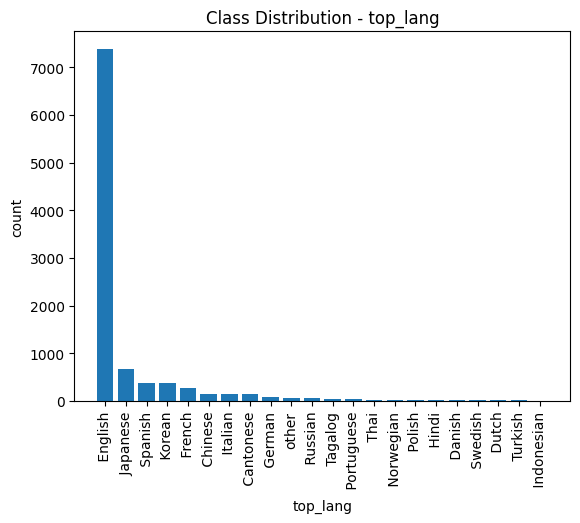

In [38]:
category = "top_lang" # type the category you'd like to explore in the quotes here

print(model_data[category].value_counts()) #print the number of observations in each class

#visualize the difference in class representation
plt.bar(model_data[category].value_counts().index.values, model_data[category].value_counts().values)
plt.ylabel('count')
plt.xlabel(category)
plt.xticks(rotation=90)
plt.title(f"Class Distribution - {category}")
plt.show()

## Fairness Metrics

We are using the Fairlearn package in Python.

You will need to understand what the metrics used below mean and how they are calculated. You can find information on the functions used in their documentation: https://fairlearn.org/v0.10/api_reference/index.html#module-fairlearn.metrics

In [39]:
# Construct a function dictionary with the metrics we'd like for each category
my_metrics = {
    'true positive rate' : true_positive_rate,
    'false positive rate' : false_positive_rate,
    'selection rate' : selection_rate,
    'count' : count
}
# Construct a MetricFrame for country
mf_country = MetricFrame(
    metrics=my_metrics,
    y_true=target_test,
    y_pred=target_predicted,
    sensitive_features=features_test["country_AU"]
)

# Construct a MetricFrame for top_lang
mf_lang = MetricFrame(
    metrics=my_metrics,
    y_true=target_test,
    y_pred=target_predicted,
    sensitive_features=features_test["top_lang_ English"]
)

# Construct a MetricFrame for top_genre
mf_genre = MetricFrame(
    metrics=my_metrics,
    y_true=target_test,
    y_pred=target_predicted,
    sensitive_features=features_test["top_genre_Drama"]
)

In [40]:
def create_confmatrix(target_test, target_predicted):
    '''
    creates a confusion matrix with more descriptive formatting
    '''
    tn, fp, fn, tp = confusion_matrix(target_test, target_predicted).ravel() # grab the individual values

    # create a data frame with the values in the correct spots
    conf_matrix = pd.DataFrame({'predicted positive': [tp, fp],
                                'predicted negative': [fn, tn]},
                                index=['actual positive','actual negative'])

    # return the dataframe to be saved/viewed
    return conf_matrix

### Overall metrics

Here is the confusion matrix for the model overall with *counts* for the true positive, false positive, true negative, and false negative.

For more information on confusion matrices, check out the wiki page: https://en.wikipedia.org/wiki/Confusion_matrix

> Use this information to answer **quesiton 4**.

In [41]:
# overall confusion matrix
print("Confusion matrix for all test data:")

# Ensure the helper function is available (in case this cell runs before its definition)
if 'create_confmatrix' not in globals():
	def create_confmatrix(target_test, target_predicted):
		'''
		creates a confusion matrix with more descriptive formatting
		'''
		tn, fp, fn, tp = confusion_matrix(target_test, target_predicted).ravel() # grab the individual values

		# create a data frame with the values in the correct spots
		conf_matrix = pd.DataFrame({'predicted positive': [tp, fp],
									'predicted negative': [fn, tn]},
									index=['actual positive','actual negative'])

		# return the dataframe to be saved/viewed
		return conf_matrix

# create and display the confusion matrix
conf_mat = create_confmatrix(target_test, target_predicted)
# overall confusion matrix
print("Confusion matrix for all test data:")

# Ensure the helper function is available (in case this cell runs before its definition)
if 'create_confmatrix' not in globals():
    def create_confmatrix(target_test, target_predicted):
        '''
        creates a confusion matrix with more descriptive formatting
        '''
        tn, fp, fn, tp = confusion_matrix(target_test, target_predicted).ravel() # grab the individual values

        # create a data frame with the values in the correct spots
        conf_matrix = pd.DataFrame({'predicted positive': [tp, fp],
                                    'predicted negative': [fn, tn]},
                                    index=['actual positive','actual negative'])

        # return the dataframe to be saved/viewed
        return conf_matrix

# create and display the confusion matrix
conf_mat = create_confmatrix(target_test, target_predicted)
print(conf_mat)

Confusion matrix for all test data:
Confusion matrix for all test data:
                 predicted positive  predicted negative
actual positive                 119                 535
actual negative                 242                1115


In [42]:
## The overall metrics. You'll use these to compare to with the metrics broken down by each category below.
## Think about how the differing performance would impact that group based on your understanding of each metric.
pd.DataFrame(mf_country.overall, columns = ["overall"]).T

,true positive rate,false positive rate,selection rate,count
overall,0.181957,0.178335,0.179513,2011.0


### Metrics by category

Here we are comparing the most prevalent class in each category to the rest of the categories.

> Use this information to answer **questions 5 & 6**.

#### `country`

The most prevalent country value is "AU". We will compare the model performance for the most prevalent country to the performance on the rest of the countries.

In [43]:
## metrics broken down by country classes. Compare these to the metrics above.
mf_country.by_group

,true positive rate,false positive rate,selection rate,count
country_AU,,,,
False,0.178914,0.171920,0.174085,1011.0
True,0.184751,0.185129,0.185000,1000.0


In [44]:
# Derived fairness metrics. Be sure you understand the scale and meaning of these.

dpr_country = fairlearn.metrics.demographic_parity_ratio(target_test, target_predicted, sensitive_features=features_test["country_AU"])
print("Demographic Parity ratio:\t", dpr_country)

eodds_country = fairlearn.metrics.equalized_odds_ratio(target_test, target_predicted, sensitive_features=features_test["country_AU"])
print("Equalized Odds ratio:\t\t", eodds_country)

Demographic Parity ratio:	 0.9410003475285375
Equalized Odds ratio:		 0.9286485978674432


#### `top_lang`


The most prevalent language value is "English". We will compare the model performance for the most prevalent language to the performance on the rest of the languages.

In [45]:
## metrics broken down by top_lang classes. Compare these to the metrics above.

mf_lang.by_group

,true positive rate,false positive rate,selection rate,count
top_lang_ English,,,,
False,0.177778,0.150142,0.159475,533.0
True,0.183544,0.188247,0.186739,1478.0


In [46]:
# Derived fairness metrics. Be sure you understand the scale and meaning of these.

dpr_lang = fairlearn.metrics.demographic_parity_ratio(target_test, target_predicted, sensitive_features=features_test["top_lang_ English"])
print("Demographic Parity ratio:\t", dpr_lang)

eodds_lang = fairlearn.metrics.equalized_odds_ratio(target_test, target_predicted, sensitive_features=features_test["top_lang_ English"])
print("Equalized Odds ratio:\t\t", eodds_lang)

Demographic Parity ratio:	 0.853998422927373
Equalized Odds ratio:		 0.7975778287393019


#### `top_genre`


The most prevalent genre value is "Drama". We will compare the model performance for the most prevalent genre to the performance on the rest of the genres.

In [47]:
## metrics broken down by top_genre classes. Compare these to the metrics above.

mf_genre.by_group

,true positive rate,false positive rate,selection rate,count
top_genre_Drama,,,,
False,0.201465,0.183150,0.189255,1638.0
True,0.083333,0.158491,0.136729,373.0


In [48]:
# Derived fairness metrics. Be sure you understand the scale and meaning of these.

dpr_genre = fairlearn.metrics.demographic_parity_ratio(target_test, target_predicted, sensitive_features=features_test["top_genre_Drama"])
print("Demographic Parity ratio:\t", dpr_genre)

eodds_genre = fairlearn.metrics.equalized_odds_ratio(target_test, target_predicted, sensitive_features=features_test["top_genre_Drama"])
print("Equalized Odds ratio:\t\t", eodds_genre)

Demographic Parity ratio:	 0.7224595693159216
Equalized Odds ratio:		 0.4136363636363636
